##Dowloading the dataset

In [1]:
 ! pip install -q kaggle

In [2]:
! mkdir ~/.kaggle

In [15]:
! cp /content/kaggle.json ~/.kaggle/

In [16]:
! chmod 600 ~/.kaggle/kaggle.json

In [17]:
! kaggle datasets list -s rsna-bone

ref                                                            title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
kmader/rsna-bone-age                                           RSNA Bone Age                                         9GB  2018-01-24 14:37:16          20825        430  0.7058824        
ipythonx/rsna-bone-age                                         RSNA Bone Age+Anatomical ROIS                        10GB  2020-08-29 17:30:09            226          7  0.75             
vbookshelf/computed-tomography-ct-images                       Brain CT Images with Intracranial Hemorrhage Masks   90MB  2019-12-04 17:43:22           7559         94  0.7058824        
abdallahgmarzouk/rsnaboneage-tfrecords                         RS

In [18]:
! kaggle datasets download kmader/rsna-bone-age

Dataset URL: https://www.kaggle.com/datasets/kmader/rsna-bone-age
License(s): other
100% 9.27G/9.29G [02:06<00:00, 65.0MB/s]
100% 9.29G/9.29G [02:06<00:00, 78.7MB/s]


In [ ]:
! unzip /content/rsna-bone-age.zip

## import packages

In [20]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## data analysis


In [21]:
train_df = pd.read_csv('/content/boneage-training-dataset.csv')
train_df['id'] = train_df['id'].apply(lambda x: str(x)+'.png')
boneage_mean = train_df['boneage'].mean()
boneage_std = train_df['boneage'].std()
train_df['boneage'] = (train_df['boneage'] - boneage_mean)/(boneage_std)

In [22]:
train_df.head()

,id,boneage,male
0,1377.png,1.279181,False
1,1378.png,-2.800269,False
2,1379.png,-0.809109,False
3,1380.png,-0.177766,True
4,1381.png,-1.100498,False


In [65]:
test_df = pd.read_excel('/content/Bone age ground truth.xlsx')
test_df['Case ID'] = test_df['Case ID'].apply(lambda x: str(x)+'.png')

In [66]:
test_df.head()

,Case ID,Sex,Ground truth bone age (months)
0,4360.png,M,168.934249
1,4361.png,M,169.652678
2,4362.png,M,73.256112
3,4363.png,M,152.862669
4,4364.png,M,135.456954


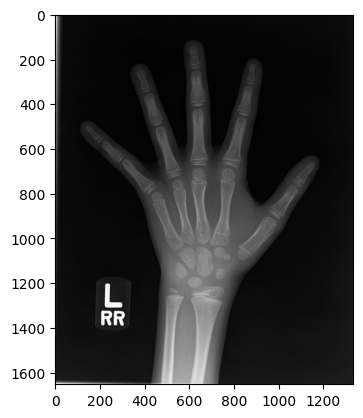

In [25]:
import cv2
img = cv2.imread("/content/boneage-training-dataset/boneage-training-dataset/10000.png")
plt.imshow(img)

Text(0.5, 1.0, 'Number of children in each age group')

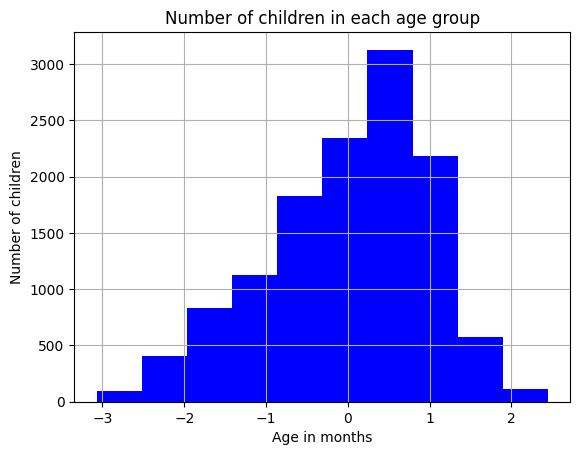

In [26]:
train_df['boneage'].hist(color = 'blue')
plt.xlabel('Age in months')
plt.ylabel('Number of children')
plt.title('Number of children in each age group')

## data preparation

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from  keras.applications.inception_v3 import preprocess_input

In [28]:
df_train, df_valid = train_test_split(train_df, test_size = 0.2, random_state = 0)

## setting up wandb

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.4 MB/s eta 0:00:00


In [ ]:
import wandb

In [ ]:
wandb.login()

wandb: Currently logged in as: reshma71995 (reshmaraj13). Use `wandb login --relogin` to force relogin


True

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

In [31]:
configs = dict(
    batch_size = 64,
    image_size = 256,
    lr = 0.001,
    epochs = 25,
    activation = "relu",
    seed = 42,
    dropout = 0.3,
    loss = "mse",
    steps_per_epoch = 75,

)

In [ ]:
run = wandb.init(
    project = "boneage_prediction_project",
    config = configs
)

In [32]:
data_augmenation = dict(rotation_range=0.2, zoom_range=0.1, horizontal_flip=True,
                                width_shift_range=0.05,
                                height_shift_range=0.05,
                                shear_range=0.05, fill_mode='nearest')
train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input,  **data_augmenation)
val_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

In [33]:
train_generator = train_data_generator.flow_from_dataframe(dataframe = df_train,
    directory = "/content/boneage-training-dataset/boneage-training-dataset",
    x_col= 'id',
    y_col= 'boneage',
    batch_size = configs["batch_size"],
    seed = configs["seed"],
    shuffle = True,
    class_mode= 'other',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (configs["image_size"], configs["image_size"]))

Found 10088 validated image filenames.


In [34]:
val_generator = val_data_generator.flow_from_dataframe(
    dataframe = df_valid,
    directory = '/content/boneage-training-dataset/boneage-training-dataset',
    x_col = 'id',
    y_col = 'boneage',
    batch_size = configs["batch_size"],
    seed = configs["seed"],
    shuffle = True,
    class_mode = 'other',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (configs["image_size"], configs["image_size"]))

Found 2523 validated image filenames.


In [67]:
test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)
test_generator = test_data_generator.flow_from_dataframe(
    dataframe = test_df,
    directory = '/content/boneage-test-dataset/boneage-test-dataset',
    x_col = 'Case ID',
    y_col = 'Ground truth bone age (months)',
    shuffle = True,
    class_mode = None,
    color_mode = 'rgb',
    target_size = (configs["image_size"],configs["image_size"]))

Found 200 validated image filenames.


In [36]:
base_model = tf.keras.applications.inception_v3.InceptionV3(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(configs["image_size"], configs["image_size"], 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

base_model.trainable = True

# Create new model on top
inputs = tf.keras.Input(shape=(configs["image_size"], configs["image_size"], 3))

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(configs["dropout"])(x)  # Regularize with dropout
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation = configs["activation"])(x)
x = tf.keras.layers.Dense(64, activation = configs["activation"])(x)
x = tf.keras.layers.Dense(32, activation = configs["activation"])(x)
outputs = tf.keras.layers.Dense(1, activation = 'linear')(x)
model = tf.keras.Model(inputs, outputs)

model.summary(show_trainable=True)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_1 (InputLayer)          │ (None, 256, 256, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ inception_v3 (Functional)           │ (None, 6, 6, 2048)           │    21,802,784 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_average_pooling2d            │ (None, 2048)                 │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout (Dropout)                   │ (None, 2048)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ flatten (Flatten)                   │ (None, 2048)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense (Dense)                       │ (None, 512)                  │     1,049,088 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_1 (Dense)                     │ (None, 64)                   │        32,832 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_2 (Dense)                     │ (None, 32)                   │         2,080 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_3 (Dense)                     │ (None, 1)                    │            33 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 22,886,817 (87.31 MB)

 Trainable params: 22,852,385 (87.17 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [37]:
AdaMax = tf.keras.optimizers.Adamax(
    learning_rate=configs["lr"], beta_1=0.9, beta_2=0.999, epsilon=1e-07)

In [38]:
from keras.metrics import mean_absolute_error
def mae_in_months(x_p, y_p):
    return mean_absolute_error((boneage_std*x_p + boneage_mean), (boneage_std*y_p + boneage_mean))

In [39]:
model.compile(
    optimizer= AdaMax,
    loss= configs["loss"],
    metrics = [mae_in_months])

In [40]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = 'inceptiov3_imsize256_model.h5',
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    initial_value_threshold=None,
)

In [41]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
   )

In [42]:
reduce_lrplateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=8,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.0)

In [ ]:
wandb_callbacks = [
        WandbMetricsLogger(),
        WandbModelCheckpoint(filepath="inceptionv3_{epoch:02d}"),
]

In [44]:
callbacks = [early_stopping, model_checkpoint, reduce_lrplateau]

In [46]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [47]:
with tf.device('/device:GPU:0'):
  history = model.fit(train_generator,
                            steps_per_epoch = configs["steps_per_epoch"],
                            validation_data = val_generator,
                            validation_steps = 1,
                            epochs = configs["epochs"], callbacks= callbacks)

Epoch 1/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.2021 - mae_in_months: 14.6928

75/75 ━━━━━━━━━━━━━━━━━━━━ 259s 3s/step - loss: 0.2020 - mae_in_months: 14.6875 - val_loss: 0.2677 - val_mae_in_months: 16.9385 - learning_rate: 0.0010
Epoch 2/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 316s 4s/step - loss: 0.1665 - mae_in_months: 13.1793 - val_loss: 0.3311 - val_mae_in_months: 18.8155 - learning_rate: 0.0010
Epoch 3/25
 8/75 ━━━━━━━━━━━━━━━━━━━━ 3:02 3s/step - loss: 0.1581 - mae_in_months: 12.7967

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 326ms/step - loss: 0.1610 - mae_in_months: 12.8532 - val_loss: 0.1702 - val_mae_in_months: 13.9004 - learning_rate: 0.0010
Epoch 4/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1607 - mae_in_months: 13.1622

75/75 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - loss: 0.1606 - mae_in_months: 13.1588 - val_loss: 0.1304 - val_mae_in_months: 11.9347 - learning_rate: 0.0010
Epoch 5/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 231s 3s/step - loss: 0.1285 - mae_in_months: 11.6886 - val_loss: 0.2728 - val_mae_in_months: 18.1621 - learning_rate: 0.0010
Epoch 6/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 535ms/step - loss: 0.1272 - mae_in_months: 11.5101 - val_loss: 0.1660 - val_mae_in_months: 13.4554 - learning_rate: 0.0010
Epoch 7/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1205 - mae_in_months: 11.3404

75/75 ━━━━━━━━━━━━━━━━━━━━ 241s 3s/step - loss: 0.1205 - mae_in_months: 11.3398 - val_loss: 0.1102 - val_mae_in_months: 10.0691 - learning_rate: 0.0010
Epoch 8/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1200 - mae_in_months: 11.3075

75/75 ━━━━━━━━━━━━━━━━━━━━ 259s 3s/step - loss: 0.1201 - mae_in_months: 11.3077 - val_loss: 0.1028 - val_mae_in_months: 10.7194 - learning_rate: 0.0010
Epoch 9/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 38s 502ms/step - loss: 0.1149 - mae_in_months: 10.8786 - val_loss: 0.1381 - val_mae_in_months: 12.7059 - learning_rate: 0.0010
Epoch 10/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - loss: 0.1125 - mae_in_months: 10.9208 - val_loss: 0.1429 - val_mae_in_months: 12.9664 - learning_rate: 0.0010
Epoch 11/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 232s 3s/step - loss: 0.1191 - mae_in_months: 11.2624 - val_loss: 0.1231 - val_mae_in_months: 11.6875 - learning_rate: 0.0010
Epoch 12/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 338ms/step - loss: 0.0987 - mae_in_months: 10.2702 - val_loss: 0.1350 - val_mae_in_months: 12.0054 - learning_rate: 0.0010
Epoch 13/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - loss: 0.1064 - mae_in_months: 10.5594 - val_loss: 0.1366 - val_mae_in_months: 11.9086 - learning_rate: 0.0010
Epoch 14/25
75/75 ━━━━━━━

75/75 ━━━━━━━━━━━━━━━━━━━━ 236s 3s/step - loss: 0.0879 - mae_in_months: 9.7241 - val_loss: 0.0791 - val_mae_in_months: 8.9845 - learning_rate: 1.0000e-04
Epoch 18/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 321ms/step - loss: 0.0777 - mae_in_months: 8.9988 - val_loss: 0.1314 - val_mae_in_months: 12.1028 - learning_rate: 1.0000e-04
Epoch 19/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 234s 3s/step - loss: 0.0799 - mae_in_months: 9.2016 - val_loss: 0.0811 - val_mae_in_months: 9.4306 - learning_rate: 1.0000e-04
Epoch 20/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 261s 4s/step - loss: 0.0793 - mae_in_months: 9.1063 - val_loss: 0.1538 - val_mae_in_months: 9.9850 - learning_rate: 1.0000e-04
Epoch 21/25
 8/75 ━━━━━━━━━━━━━━━━━━━━ 3:11 3s/step - loss: 0.0826 - mae_in_months: 9.1089

75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 327ms/step - loss: 0.0787 - mae_in_months: 8.8664 - val_loss: 0.0688 - val_mae_in_months: 8.9231 - learning_rate: 1.0000e-04
Epoch 22/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 235s 3s/step - loss: 0.0746 - mae_in_months: 8.8450 - val_loss: 0.0720 - val_mae_in_months: 9.1718 - learning_rate: 1.0000e-04
Epoch 23/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 261s 4s/step - loss: 0.0733 - mae_in_months: 8.7742 - val_loss: 0.0952 - val_mae_in_months: 9.8942 - learning_rate: 1.0000e-04
Epoch 24/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 336ms/step - loss: 0.0696 - mae_in_months: 8.6138 - val_loss: 0.0954 - val_mae_in_months: 10.3632 - learning_rate: 1.0000e-04
Epoch 25/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 234s 3s/step - loss: 0.0763 - mae_in_months: 8.9557 - val_loss: 0.0752 - val_mae_in_months: 9.1597 - learning_rate: 1.0000e-04


In [79]:
def plotlosscurve(history):
    '''function to plot training and validation loss'''
    fig, ax = plt.subplots( figsize=(5,5))
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    plt.title('loss curve')
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    ax.grid(color='black')
    plt.show()

In [80]:
def ploterrorcurve(history):
    '''function to plot training and validation error'''
    fig, ax = plt.subplots( figsize=(5,5))
    ax.plot(history.history['mae_in_months'])
    ax.plot(history.history['val_mae_in_months'])
    plt.title('Error curve')
    plt.ylabel('Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    ax.grid(color='black')
    plt.show()

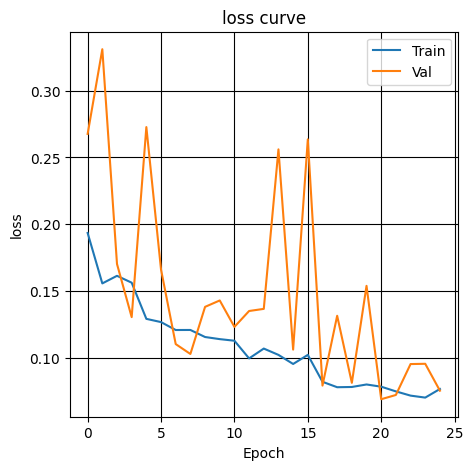

In [81]:
plotlosscurve(history)

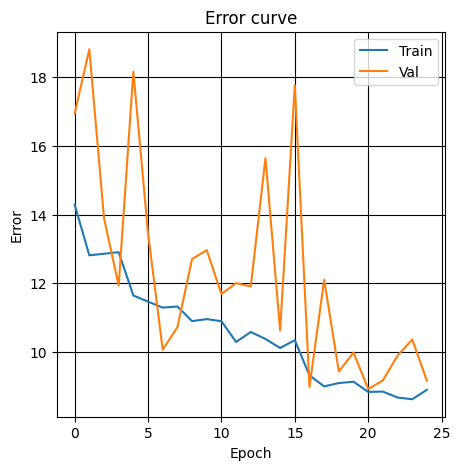

In [82]:
ploterrorcurve(history)

In [70]:
predictions = model.predict(test_generator)
predictions_1 = predictions.reshape(-1)
y_months = boneage_std*predictions_1 + boneage_mean
results=pd.DataFrame({"ID":test_df['Case ID'],"prediction":y_months})
results.to_csv("boneage_testdata_prediction.csv")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 783ms/step


In [71]:
accuracy_of_testdata = mean_absolute_error(test_df['Ground truth bone age (months)'], y_months)

In [72]:
print(accuracy_of_testdata)

tf.Tensor(48.32994, shape=(), dtype=float32)


Text(0, 0.5, 'Predicted Age (Months)')

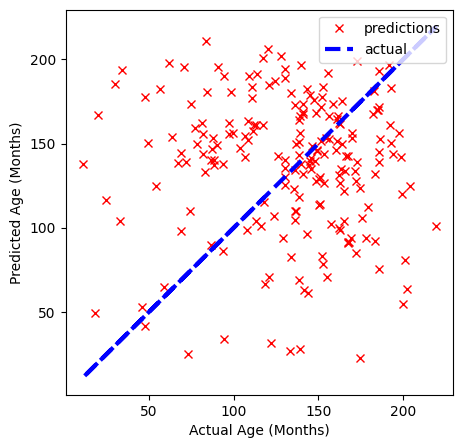

In [78]:
fig, ax = plt.subplots( figsize=(5,5))
ax.plot(test_df['Ground truth bone age (months)'], y_months, 'red',linestyle=" ",marker="x" ,label = 'predictions')
ax.plot(test_df['Ground truth bone age (months)'], test_df['Ground truth bone age (months)'], 'blue', linestyle="--",linewidth=3.0,label = 'actual')
ax.legend(loc = 'upper right')
ax.set_xlabel('Actual Age (Months)')
ax.set_ylabel('Predicted Age (Months)')